## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

# 1 Writeup / README

###  Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  


## Here you are reading it

# 2 Camera Calibration

### I used findImgsPoints() to return the objpoints and imgpoints.
### All the pre-defined function are in helper.py
### Inside findImagsPoints(), there is cv2.findChessboardCorners() which is used to get the corners used as imgpoints.
### objpoints and imgpoints are used for cv2.calibrateCamera() to return mtx and dist for the camera.

### here is the code

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper import *
%matplotlib qt

In [2]:
# prepare the objpoints and imgpoints
filenames = '../camera_cal/calibration*.jpg'
objpoints, imgpoints = findImgsPoints(filenames, nx=9, ny=6)

image = mpimg.imread('../camera_cal/calibration1.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# 3 Pipeline (test images)

## 3.1 Provide an example of a distortion-corrected image. 

### then undistort() used to return the undistorted image
### inside the undistort(), there's cv2.undistort(image, mtx, dist, None, mtx)

True

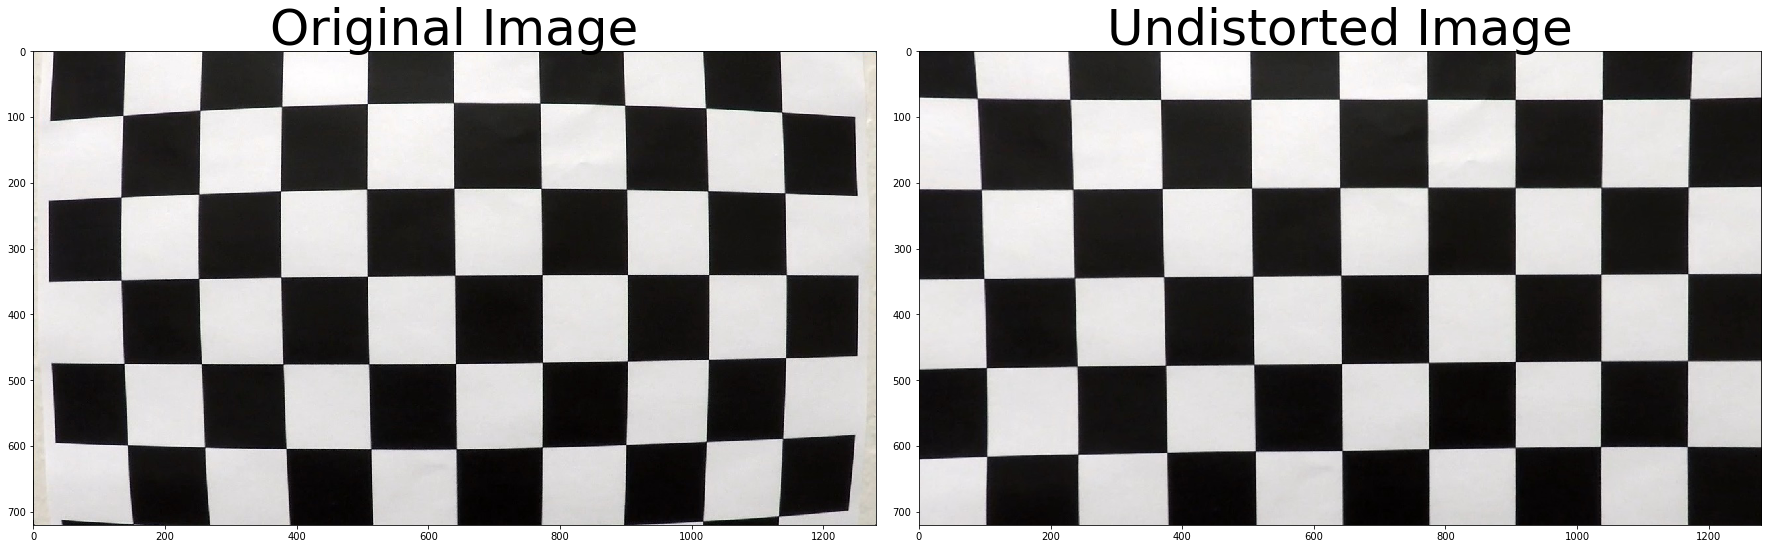

In [3]:
undistorted = undistort(image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("../output_images/calibration1_undist.jpg", image)


## 3.2 Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

### I compared several methods like color transform and different gradients, then color transform is more useful
### use combined_thresh() to filter L channel based on magnatitude and direction, no extra filter for S channel
### combined S channel and filtered L channel together to get final binary image
### these functions are all defined in helper.py


### here is the result of binary image

In [10]:
image = mpimg.imread('../test_images/straight_lines1.jpg')
undist = undistort(image, mtx, dist)

## get the binary image of the birdeye
# Choose a Sobel kernel size
ksize = 5
s_binary = hls_select(undist, channel='S', thresh=(90, 255))
#combined_s = combined_thresh(undist,ksize, grad_thresh=(50, 255), dir_thresh=(0.7, 1.3))

l_binary = hls_select(undist, channel='L', thresh=(90, 255))
combined_l = combined_thresh(l_binary,ksize, grad_thresh=(50, 255), dir_thresh=(0.7, 1.3))

binary_birdeye = np.zeros_like(s_birdeye)
binary_birdeye[(s_binary==1)|(combined_l==1)] = 1
## end binary birdeye func ##



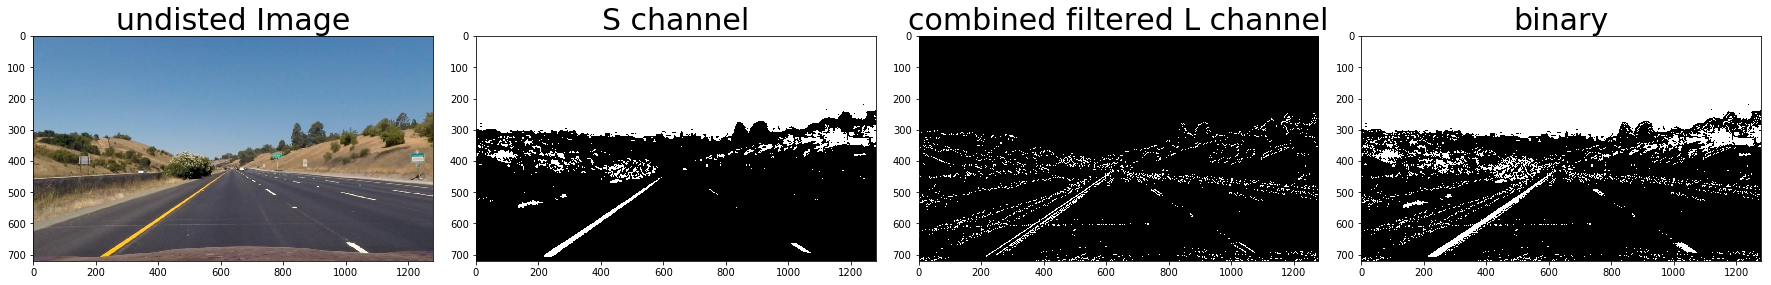

In [11]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('undisted Image', fontsize=30)
ax2.imshow(s_birdeye,'gray')
ax2.set_title('S channel', fontsize=30)
ax3.imshow(combined_l, cmap='gray')
ax3.set_title('combined filtered L channel', fontsize=30)
ax4.imshow(binary_birdeye, cmap='gray')
ax4.set_title('binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3.3 Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

### firstly defined the poly in the source image named "src", then defined the destinated poly in the perspective image named " dst "
### then the corners_unwarp() in helper is used to return the perspective image

In [12]:

img_size = s_binary.shape[::-1]

height_low = img_size[1]//3*2
height_high = img_size[1]

width_low = img_size[0]//6 
width_high = img_size[0]//6*5 
width_mid = img_size[0]//2

# very important to chose appropriate src
# the vertical lines of src should be merged together to a point
src = np.float32(
    [[(width_mid-80), height_low-20],
    [(width_mid+80), height_low-20],
    [(width_high+130), height_high],
    [(width_low-100), height_high]])

dst = np.float32(
    [[(img_size[0]/4), 0],
    [(img_size[0]*3/4+30), 0],
    [(img_size[0]*3/4+30), img_size[1]],
    [(img_size[0]/4), img_size[1]]])


lineimg = np.copy(undist)*0
cv2.line(lineimg,(src[0,0],src[0,1]),(src[1,0],src[1,1]),(255,0,0),5)
cv2.line(lineimg,(src[0,0],src[0,1]),(src[3,0],src[3,1]),(255,0,0),5)
cv2.line(lineimg,(src[2,0],src[2,1]),(src[1,0],src[1,1]),(255,0,0),5)
cv2.line(lineimg,(src[3,0],src[3,1]),(src[2,0],src[2,1]),(255,0,0),5)

lines_edges = cv2.addWeighted(undist, 1, lineimg, 1, 0) 

birdeye, perspective_M = corners_unwarp(undist,src,dst, (1280,720))

lineimg = np.copy(birdeye)*0
cv2.line(lineimg,(dst[0,0],dst[0,1]),(dst[1,0],dst[1,1]),(255,0,0),5)
cv2.line(lineimg,(dst[0,0],dst[0,1]),(dst[3,0],dst[3,1]),(255,0,0),5)
cv2.line(lineimg,(dst[2,0],dst[2,1]),(dst[1,0],dst[1,1]),(255,0,0),5)
cv2.line(lineimg,(dst[3,0],dst[3,1]),(dst[2,0],dst[2,1]),(255,0,0),5)
birdeye_edges = cv2.addWeighted(birdeye, 1, lineimg, 1, 0) 

#mpimg.imsave("../output_images/line_image.jpg", lines_edges)

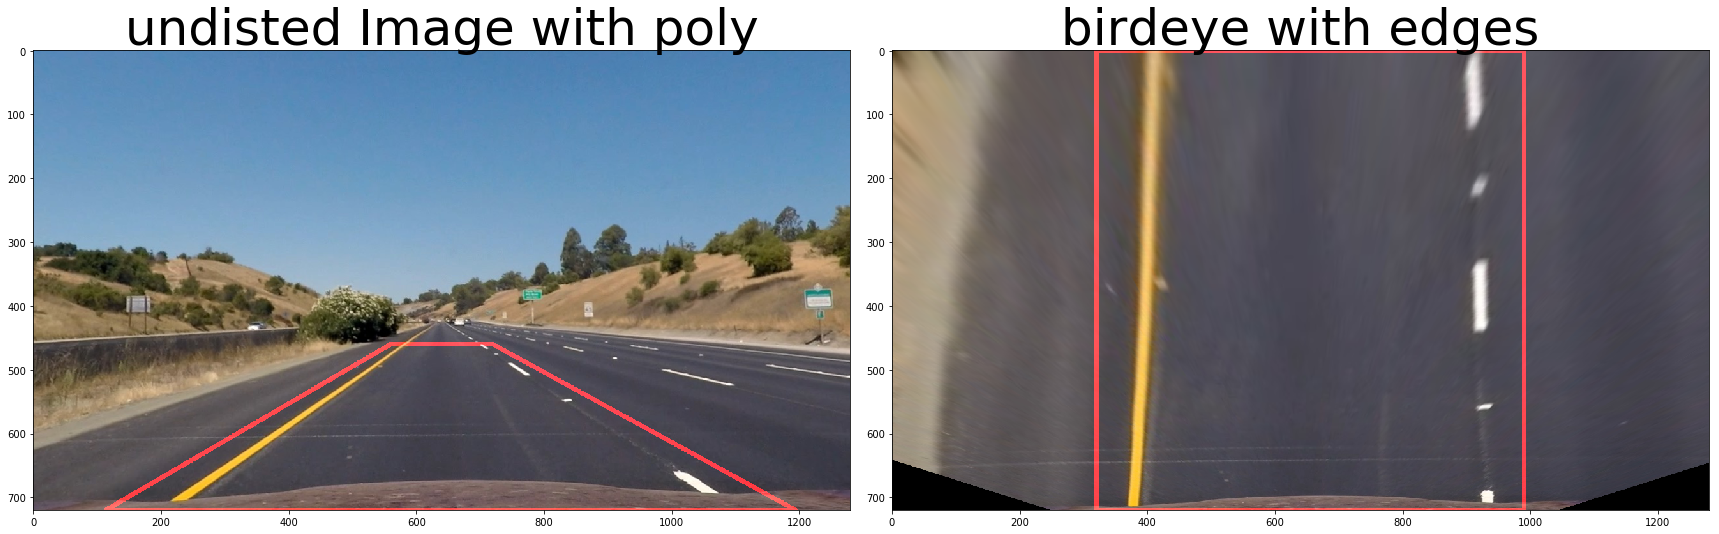

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(lines_edges)
ax1.set_title('undisted Image with poly', fontsize=50)
ax2.imshow(birdeye_edges)
ax2.set_title('birdeye with edges', fontsize=50)
mpimg.imsave("../output_images/line_image.jpg", lines_edges)
mpimg.imsave("../output_images/birdeye_edges.jpg", birdeye_edges)

## 3.4 Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

### firstly the histgram method is used to get the hist on the bottom half of the binary image.
### then used sliding window to detect the pixels and fit them to a second order polynomial. find_lane_pixels() and fit_polynomial() are used at this step
### In the video pipeline, search_around_poly() is also used to find the lane pixels in the window of fitted line +/- margine after the polynomial already available from last frame


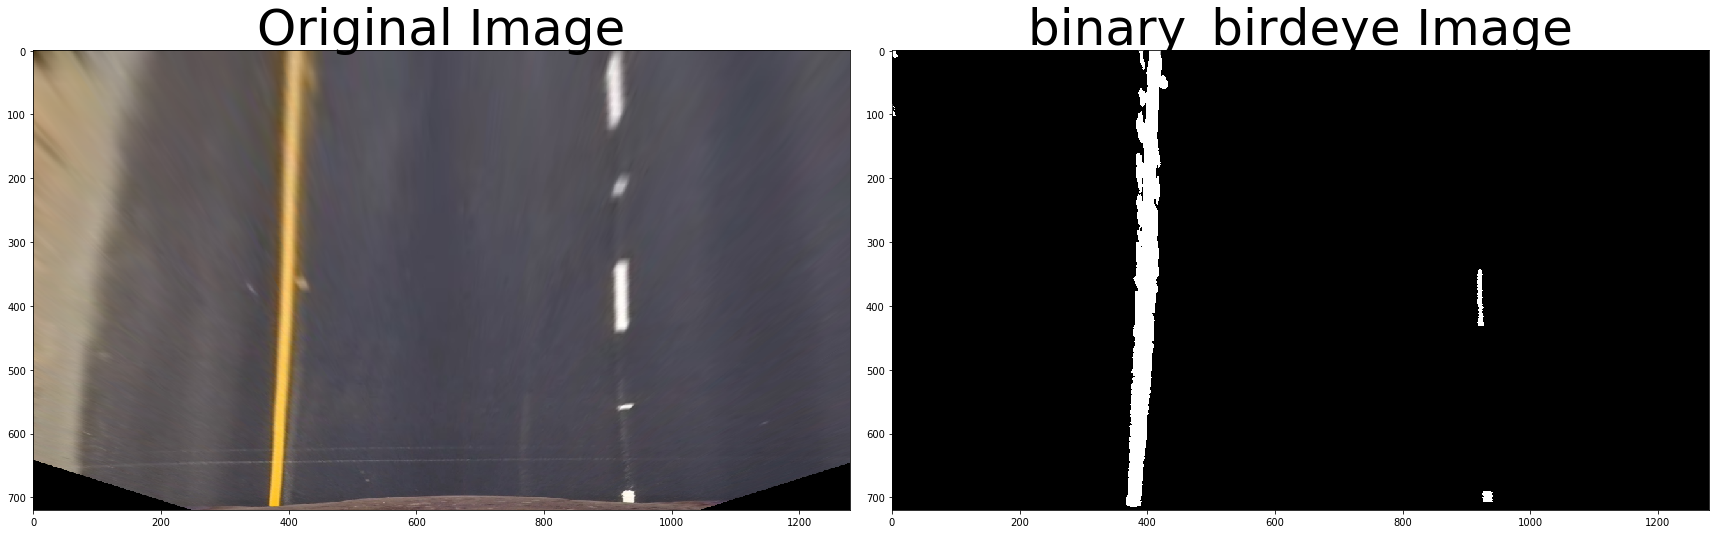

In [14]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements
binary_birdeye = hls_select(birdeye, channel='S', thresh=(90, 255))
# Apply each of the thresholding functions


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(birdeye)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_birdeye,cmap='gray')
ax2.set_title('binary_birdeye Image', fontsize=50)
mpimg.imsave("../output_images/binary_birdeye.jpg", binary_birdeye)


### also used prefered poly which is defined by vertices to filter the interested area
### the function used here is binary_masked

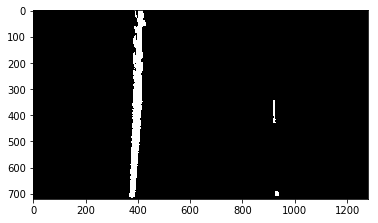

In [15]:
vertices = np.int32(dst)
vertices[1][0] += 100
vertices[2][0] += 100
binary_mask = binary_masked(binary_birdeye, vertices)
plt.imshow(binary_mask,'gray')

### hist() used to return the histogram of the binary image

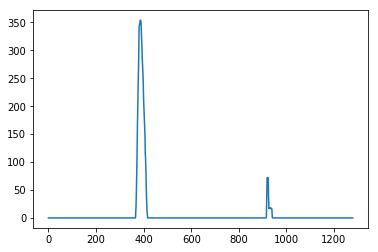

In [16]:
# Create histogram of image binary activations
histogram = hist(binary_mask)

# Visualize the resulting histogram
plt.plot(histogram)
plt.show()


### here is the code example of fit_polynomial

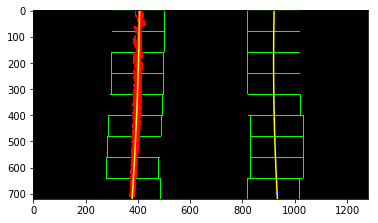

In [17]:
out_img, ploty, left_fit, right_fit = fit_polynomial(binary_mask)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

### here is the code example of search_around_poly()

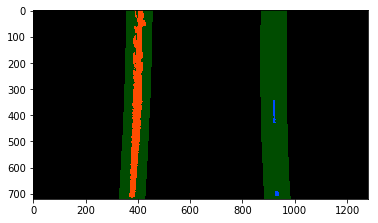

In [18]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
# # when the test4.jpg tested, the plotfit right lane is not right
## After giving a smaller margin here, the result is good
result,ploty, left_fit, right_fit = search_around_poly(binary_mask, left_fit, right_fit, margin=50)

# View your output
plt.imshow(result)

## 3.5 Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

### first, hard code of the ratio between pixels and meters is defined here
### ym_per_fix = 30/720, xm_per_pix = 3.7/555
### the real curvature of the lane is calculated by measure_curvature_real()
### the car center is calculated by car_offset(), which the negtive value means right to the lane center and positive value means left to the lane center
### all the units are meter
### here is the code example


In [19]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/555 # meters per pixel in x dimension

left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty, ym_per_pix, xm_per_pix)
offset, lane_width_cr, lane_width = car_offset(binary_mask, left_fit, right_fit, xm_per_pix)

print(left_curverad, right_curverad, offset)

3688.02929954 2468.55896867 -0.1


### draw_lane_window() is used for draw the lane area

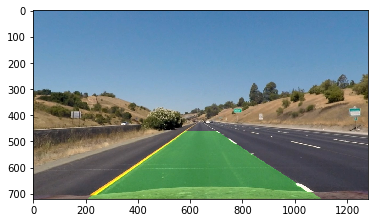

In [20]:
result = draw_lane_window(undist, binary_mask, src, dst, left_fit, right_fit, ploty)
plt.imshow(result)

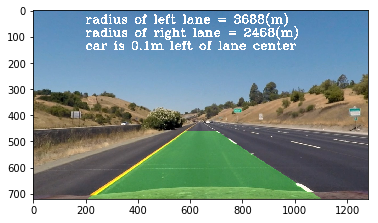

In [21]:
text1 = 'radius of left lane = '+ str(int(left_curverad)) + '(m)'
text2 = 'radius of right lane = '+ str(int(right_curverad)) + '(m)'
if offset<=0 :
    text3 = "car is " + str(abs(offset)) + "m" + " left of lane center"
if offset>0 :
    text3 = "car is " + str(abs(offset)) + "m" + " right of lane center"

cv2.putText(result,text1,(200,50),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
cv2.putText(result,text2,(200,100),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
cv2.putText(result,text3,(200,150),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
plt.imshow(result)
mpimg.imsave("../output_images/lane_area.jpg", result)

## 3.6 Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

### here is the video pipeline

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper import *
%matplotlib qt

In [2]:
# prepare the objpoints and imgpoints
filenames = '../camera_cal/calibration*.jpg'
objpoints, imgpoints = findImgsPoints(filenames, nx=9, ny=6)

image = mpimg.imread('../camera_cal/calibration1.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
def findlane_pipeline(image):
    global mtx, dist
    global lane_fit
    global left_fit_avg, right_fit_avg
    global lane_saved_number
    
    undist = undistort(image, mtx, dist)

    s_binary = hls_select(undist, channel='S', thresh=(200, 255))

    img_size = s_binary.shape[::-1]

    height_low = img_size[1]//3*2
    height_high = img_size[1]

    width_low = img_size[0]//6 
    width_high = img_size[0]//6*5 
    width_mid = img_size[0]//2

    # very important to chose appropriate src
    # the vertical lines of src should be merged together to a point
    src = np.float32(
        [[(width_mid-80), height_low-20],
        [(width_mid+80), height_low-20],
        [(width_high+130), height_high],
        [(width_low-100), height_high]])

    dst = np.float32(
        [[(img_size[0]/4), 0],
        [(img_size[0]*3/4+30), 0],
        [(img_size[0]*3/4+30), img_size[1]],
        [(img_size[0]/4), img_size[1]]])

    birdeye, perspective_M = corners_unwarp(undist,src,dst, (1280,720))

    ## get the binary image of the birdeye
    # Choose a Sobel kernel size
    ksize = 5
    s_birdeye = hls_select(birdeye, channel='S', thresh=(90, 255))
    #combined_s = combined_thresh(s_birdeye,ksize, grad_thresh=(50, 255), dir_thresh=(0.7, 1.3))

    l_birdeye = hls_select(birdeye, channel='L', thresh=(90, 255))
    combined_l = combined_thresh(l_birdeye,ksize, grad_thresh=(50, 255), dir_thresh=(0.7, 1.3))

    binary_birdeye = np.zeros_like(s_binary)
    binary_birdeye[(s_birdeye==1)|(combined_l==1)] = 1
    ## end binary birdeye func ##

    # define the vertices of interested poly
    vertices = np.int32(dst)
    vertices[1][0] += 100
    vertices[2][0] += 100

    ## when binary_mask = binary_mask(), output as the same name of function, report error
    ## changing the function name, error is killed
    binary_mask = binary_masked(binary_birdeye, vertices)

    # Create histogram of image binary activations
    histogram = hist(binary_mask)
    
    left_fit = np.copy(left_fit_avg)
    right_fit = np.copy(right_fit_avg)
    
    if (((left_fit==[0,0,0]).all())|((right_fit==[0,0,0]).all()))!=True:
        out_img, ploty, left_fit, right_fit = search_around_poly(binary_mask, left_fit, right_fit, margin=50)
        
    else:
        out_img, ploty, left_fit, right_fit = fit_polynomial(binary_mask)
    
    ## filter function to smooth the lane
    filter = 200 # 300
    if len(lane_fit)>0:
        left_diff = (left_fit-lane_fit[-1][0])
        right_diff = (right_fit-lane_fit[-1][1])
        if (abs(left_diff[0]*ploty**2+left_diff[1]*ploty+left_diff[2]) > filter).any():
            left_fit = left_fit_avg
        if (abs(right_diff[0]*ploty**2+right_diff[1]*ploty+right_diff[2]) > filter).any():
            right_fit = right_fit_avg
    ## filter function end
    
    ## undate the lane_fit, left_lane_avg, right_lane_avg
    if len(lane_fit)>= lane_saved_number:
        for i in range(lane_saved_number - 1):
            lane_fit[i] = lane_fit[i+1]
        lane_fit[(lane_saved_number - 1)] = (left_fit, right_fit)
    else:
        lane_fit.append((left_fit,right_fit))
    
    left_sum = np.float32(np.zeros_like(left_fit))
    right_sum = np.float32(np.zeros_like(right_fit))
    for i in range(len(lane_fit)):
        left_sum += lane_fit[i][0]
        left_fit_avg = np.array(left_sum/len(lane_fit))
        right_sum += lane_fit[i][1]
        right_fit_avg = np.array(right_sum/len(lane_fit))
    
    ## global variables undate function end
    

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/555 # meters per pixel in x dimension
    left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty, ym_per_pix, xm_per_pix)

    offset, lane_width_cr, lane_width = car_offset(binary_mask, left_fit, right_fit, xm_per_pix)

    result = draw_lane_window(undist, binary_mask, src, dst, left_fit, right_fit, ploty)

    text1 = 'radius of left lane = '+ str(int(left_curverad)) + '(m)'
    text2 = 'radius of right lane = '+ str(int(right_curverad)) + '(m)'
    if offset<=0 :
        text3 = "car is " + str(abs(round(offset,3))) + "m" + " left of lane center"
    if offset>0 :
        text3 = "car is " + str(abs(round(offset,3))) + "m" + " right of lane center"


    cv2.putText(result,text1,(100,50),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
    cv2.putText(result,text2,(100,100),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
    cv2.putText(result,text3,(100,150),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
    
    return result

### a list named lane_fit is used for storing the caculated polynomials of last frames
### lane_fit[0]=(left_fit, right_fit)
### the number of the saved frames is defined by "lane_saved_number"
### left_fit_avg and right_fit_avg also used for the average lane polynomial
### lane_fit, left_fit_avg, and right_fit_avg are updated in findlane_pipeline()

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_fit = []
left_fit_avg = np.array([0,0,0])
right_fit_avg = np.array([0,0,0])

lane_saved_number = 20

In [5]:
normal_output = './output_images/normal_test.mp4'

clip1 = VideoFileClip("../project_video.mp4")
normal_clip = clip1.fl_image(findlane_pipeline) #NOTE: this function expects color images!!
%time normal_clip.write_videofile(normal_output, audio=False)

[MoviePy] >>>> Building video ./output_images/normal_test.mp4
[MoviePy] Writing video ./output_images/normal_test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:01<00:00,  5.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/normal_test.mp4 

Wall time: 4min 1s


### the output project video is in /output_images/normal_test.mp4